# Section 12 k-NN, Decision Tree and Random Forest

In previous lectures, we take linear regression and logistic regression as examples to form a (relatively) rigorous mathematical framework of **supervised learning**:

1. Define the **supervised learning** problem as function fitting problem $y\approx f(x)$: 

    Determine the function by using **training data** (providing both true $x$ and $y$). With this $f$, make predictions on **test data** (only $x$ is necessary, although sometimes $y$ is also provided to evaluate the performance).
    
    
2. Make assumptions about the form of $f(x;\beta)$ by introducting parameters $\beta$ (or $w$, $W$)-- assumptions lead to models;


3. Derive the concrete form of Loss function $L(\beta)$. The most common approach is maximum likelihood estimation, which measures "how good" $f(x;\beta)$ fits the actual $y$ given the paramter $\beta$;


4. Minimize (analytically or numerically) the Loss function $L(\beta)$ on **training data**, to find a reasonable parameter $\hat{\beta}$; (this step is called "fit" in sklearn)


5. On the test data, make predictions (called "predict" in sklearn) . If true labels are also known in test dataset, using metrics (R-squared,accuracy) to evaluate the performace (called "score" in sklearn).

Meanwhile, there exists other supervised learning approaches that might not strictly follow this guidline. Sometimes the function $f$ or the loss function $L$ are not explictly used. At first glance, these methods are rather heuristic or even "naive" -- while they can really give surprisingly good results. In this section, we are going to introduce some important algorithms of such style.

## [k-NN (k-nearest neighbor classifier)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

**Intuitions**: To make a prediction of test sample, we don't have to always derive the mapping formula explicitly -- we just look at its "close friends" in training dataset, and follow its friends' label! **Do as what your neighbors do**.

**Mathematical Description**: Given a test sample $\mathbf{x}$ from **test** dataset, the kNN classifier first identifies the neighbors $k$ points in the **training** data that are closest to $\mathbf{x}$, whose indices are represented by $\mathcal{N}_{x}$. It then estimates the probability that $\mathbf{x}$ belongs to class $j$ by $P\big(y= j| \mathbf{x} \big)$ computing the fraction of points in $\mathcal{N}$ whose label(s) actually equal $j$:

$$
P\big(y= j| \mathbf{x} \big)\approx  \frac{1}{k} \sum_{i\in \mathcal{N}_{x}} \mathbb{1}\{ y^{(i)} = j\}.
$$

We finally determine its class by picking up the class with largest probability.

*Remark*: The similar philosophy can also extend to regression problem, which is called kNN regression.

In [1]:
from sklearn.datasets import load_iris
X,y = load_iris(return_X_y = True)

In [2]:
help(load_iris) #Optional: recall information about our iris species dataset

Help on function load_iris in module sklearn.datasets._base:

load_iris(*, return_X_y=False, as_frame=False)
    Load and return the iris dataset (classification).
    
    The iris dataset is a classic and very easy multi-class classification
    dataset.
    
    =================   ==============
    Classes                          3
    Samples per class               50
    Samples total                  150
    Dimensionality                   4
    Features            real, positive
    =================   ==============
    
    Read more in the :ref:`User Guide <iris_dataset>`.
    
    Parameters
    ----------
    return_X_y : bool, default=False.
        If True, returns ``(data, target)`` instead of a Bunch object. See
        below for more information about the `data` and `target` object.
    
        .. versionadded:: 0.18
    
    as_frame : bool, default=False
        If True, the data is a pandas DataFrame including columns with
        appropriate dtypes (numeric).

In [3]:
import pandas as pd

#This cell is completely optional and is provided for context
iris = load_iris(as_frame=True)
df_iris = pd.DataFrame(iris.data,columns=iris.feature_names)
df_iris['target'] = pd.Series(iris.target)
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In practice, the challenging question is always choosing the correct $k$ (parameter tuning). Recall that a powerful strategy is to use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 20)
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test,y_test)

1.0

In [6]:
import pandas as pd
from sklearn.model_selection import cross_val_score

k_list = list(range(1,50,10))
# creating dataframe of cv scores and test scores -- of course you can also use Numpy array
cv_scores = pd.DataFrame()
test_scores = pd.Series(dtype = 'float64')

# perform 10-fold cross validation
for k in k_list:
    knn_clf.set_params(n_neighbors=k) # update the object
    scores = cross_val_score(knn_clf, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores["K="+str(k)] = scores
    test_scores[str(k)] = knn_clf.score(X_test,y_test)

In [7]:
cv_scores

,K=1,K=11,K=21,K=31,K=41
0,0.888889,0.777778,0.777778,0.777778,0.777778
1,1.000000,1.000000,1.000000,0.888889,0.888889
2,1.000000,0.888889,0.888889,0.888889,0.888889
3,0.666667,0.777778,0.777778,0.777778,0.888889
4,0.888889,1.000000,0.888889,0.888889,0.888889
5,1.000000,1.000000,1.000000,0.888889,0.888889
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,0.777778,0.777778
9,0.888889,0.888889,0.888889,0.888889,0.888889


In [8]:
cv_scores.mean()

K=1     0.933333
K=11    0.933333
K=21    0.922222
K=31    0.877778
K=41    0.888889
dtype: float64

In [9]:
cv_scores.std()

K=1     0.107344
K=11    0.093697
K=21    0.091475
K=31    0.081985
K=41    0.074074
dtype: float64

<AxesSubplot:>

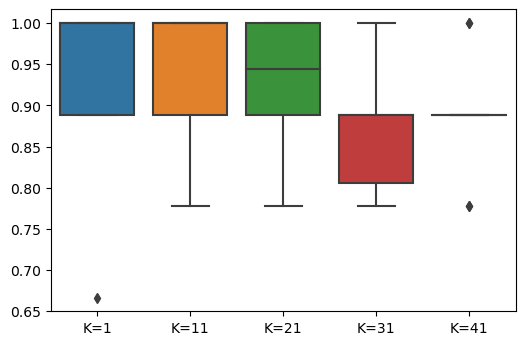

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=100)
sns.boxplot(data =cv_scores)

In [11]:
test_scores

1     0.983333
11    1.000000
21    1.000000
31    0.983333
41    0.950000
dtype: float64

### Bias-Variance Tradeoff in kNN:
The parameter k (number of neighbors) is important to determine the final performance of classification, which can be understood as control the complexity of algorithm.
- **small k**: increase complexity, low bias, large variance
- **large k**: decrease complexity, high bias, low variance

Recall that roughly,  **total error = bias + variance**, therefore the test error might not be a monotonic function of algorithm complexity (k here), so that we need to select a moderate k for best performance. The common strategy is through cross-validation.

## [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning)

How do human-beings make classifications? Instead of using mathematical equations, we actually make a series of "decisions" based on the important features that are drawn from our past experience.

**Intuitions**: By repeatedly setting threshold for different features (multiple if-else conditions -- forming a flow-chart or decision tree structure), we can naturally achieve the classification task.

**Mathematical Considerations**: How to decide the appropriate thresholds and the order of if-else conditions? **Gini impurity** or **Entropy** (not required in this class). You only need to know that these tresholds/order of conditions are determined by the training dataset, using certain metrics to select. Different concerete strategies lead to various algorithms, known as ID3, CART, C4.5...

For the basic requirements, in this course we only ask you to call the package and understand how to interpret the results.

In [12]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
dt_clf.score(X_test,y_test)

0.9833333333333333

In [13]:
import numpy as np
dt_clf.predict(np.array([6,3,5.5,1]).reshape(1,4))

array([2])

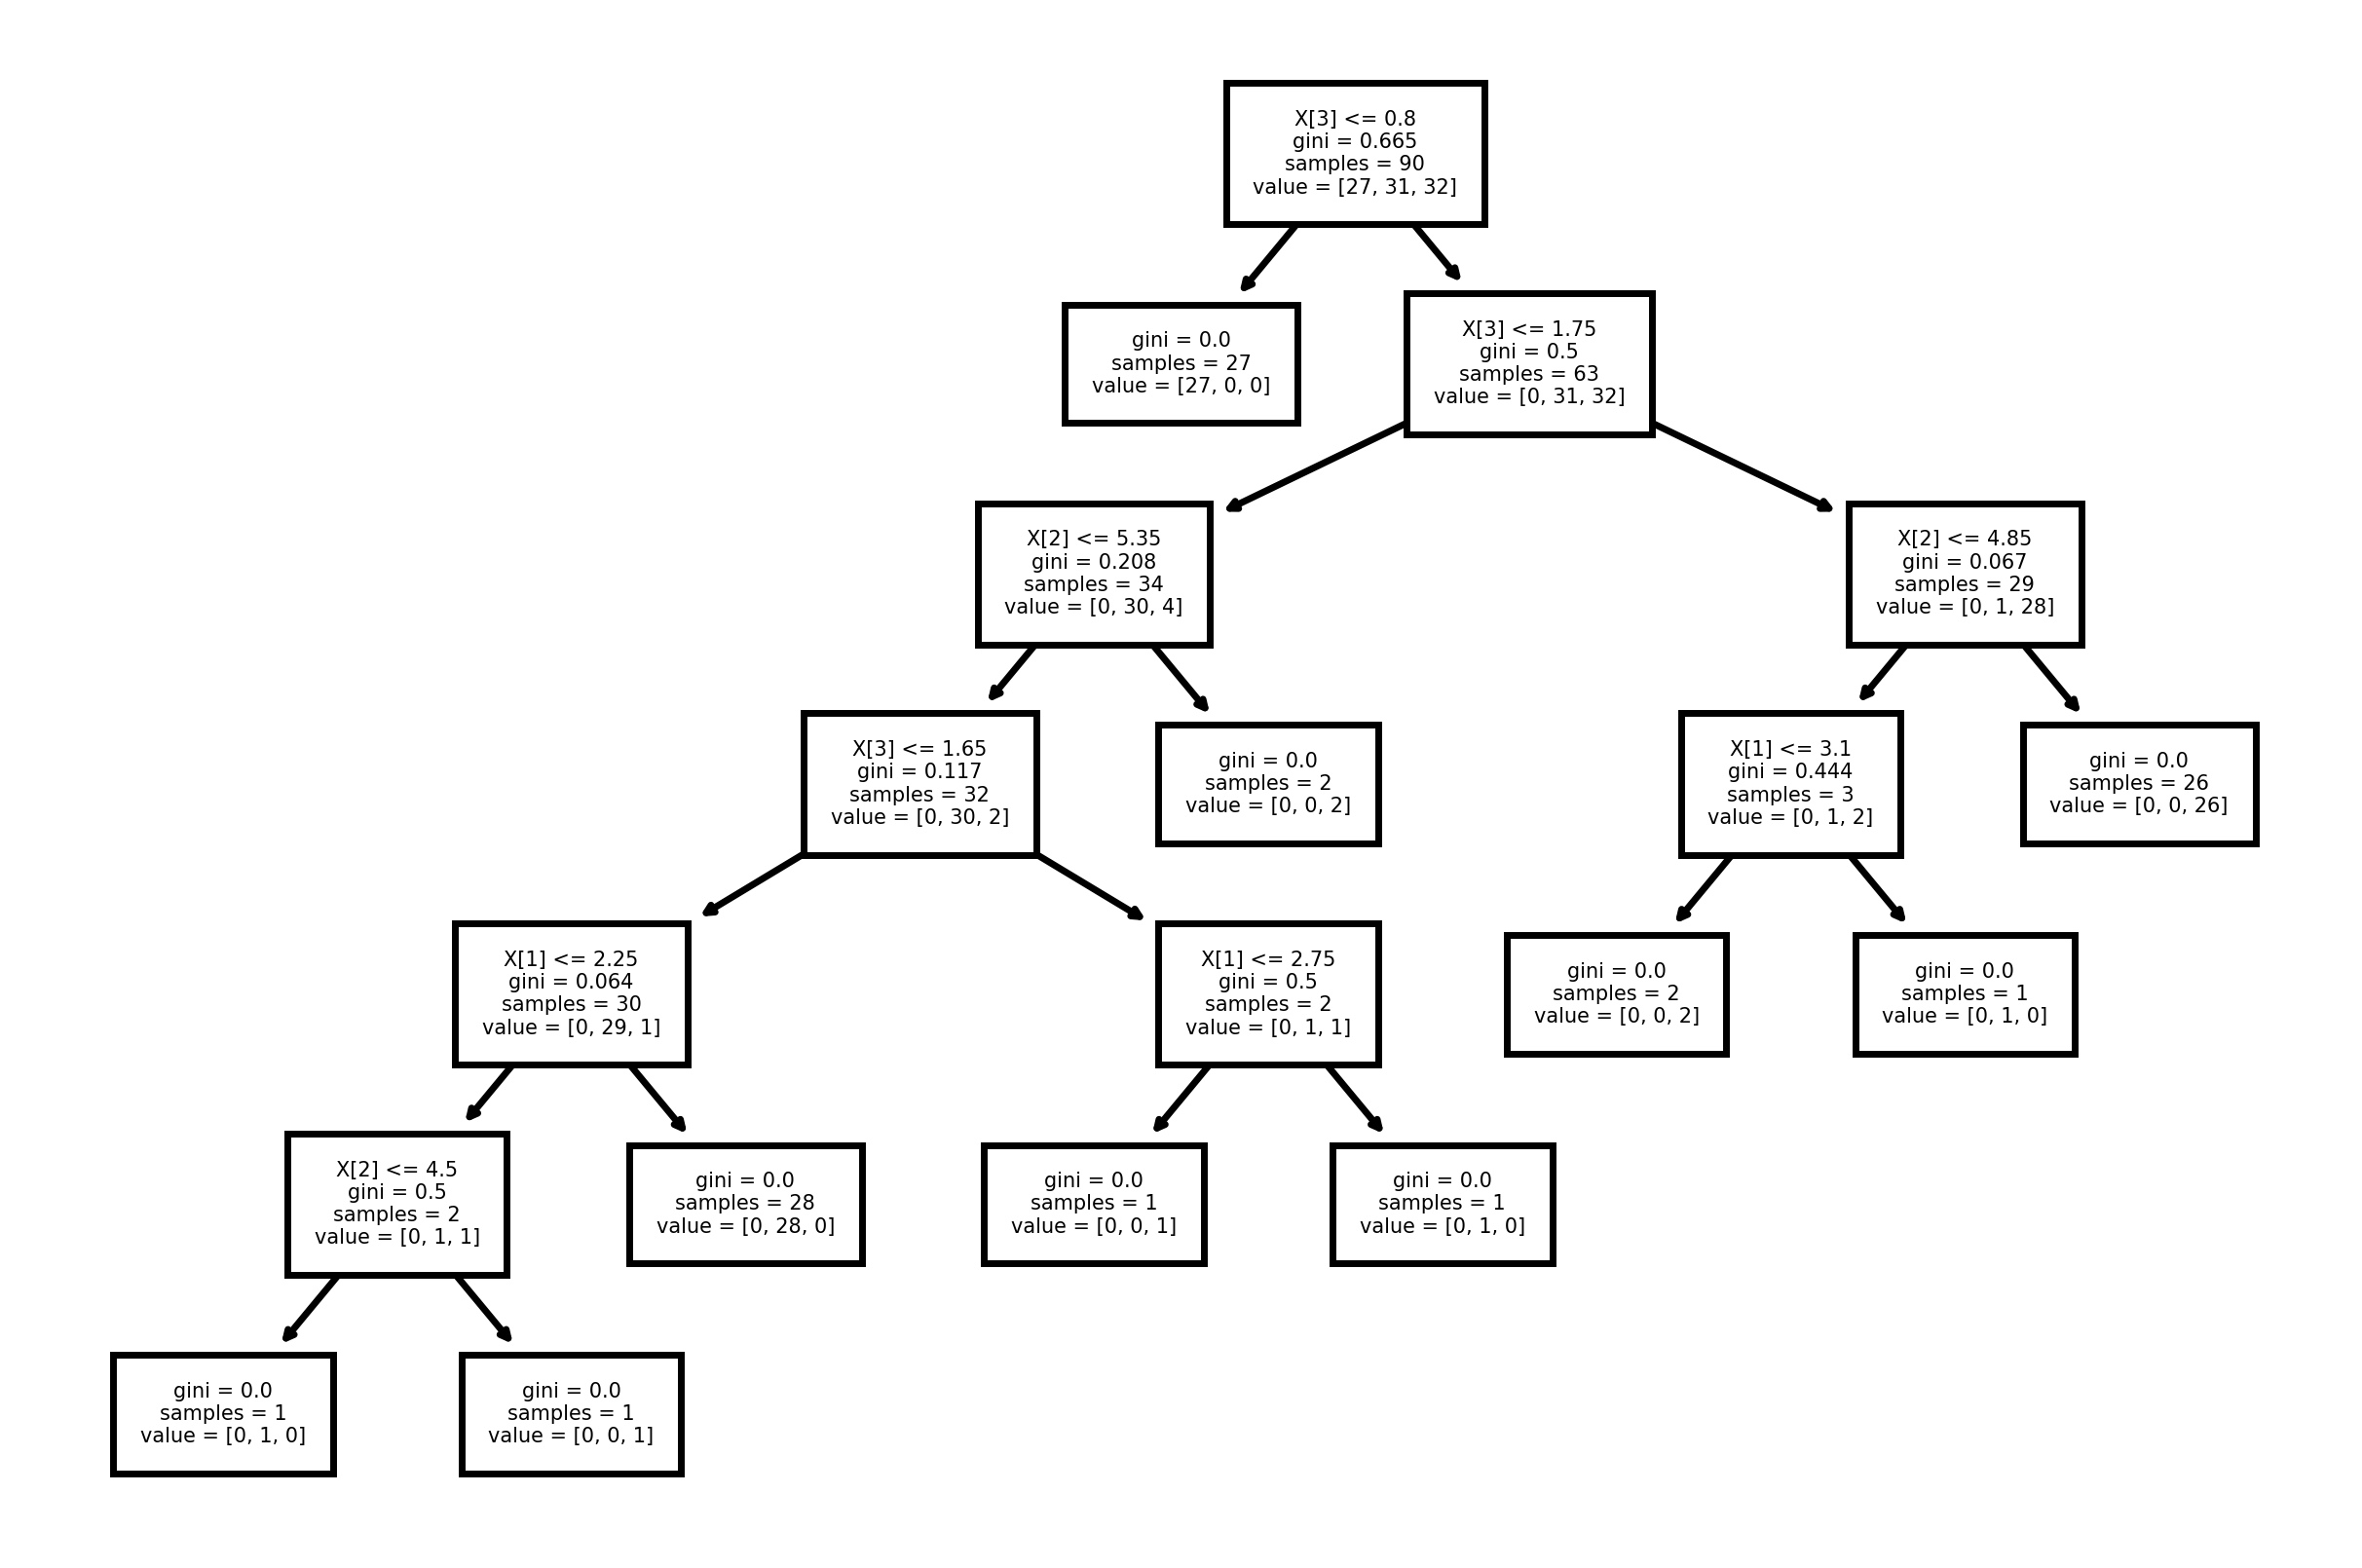

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=500)
tree.plot_tree(dt_clf,fontsize=3) 
plt.show()
#True is the left branch. False is the right branch.
#first box is decision regarding 'petal width (cm)' <= 0.8

In [15]:
df_iris.columns #again, this is optional and only for context

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

To visualize the trees more elegantly, we can use the graphviz package ([installment](https://scikit-learn.org/stable/modules/tree.html) is not basic requirement of our course, and the easiest way is through [conda command line](https://tljh.jupyter.org/en/latest/howto/env/user-environment.html)).

**Specifically for graphviz:**
1. Open Anaconda, and then Jupyter Notebook

2. Create a new terminal

3. enter `conda install graphviz`
  * This is the list of binaries for graphviz
  
4. enter `conda install python-graphviz`
  * This allows graphviz to communicate with Python
  
5. enter `conda install pydot`
  * Graphviz is written in the DOT language. Pydot can parse and dump in DOT language to be used for Graphviz.
  
6. (Optional) It's typically a good idea to end your terminal session by typing `exit`

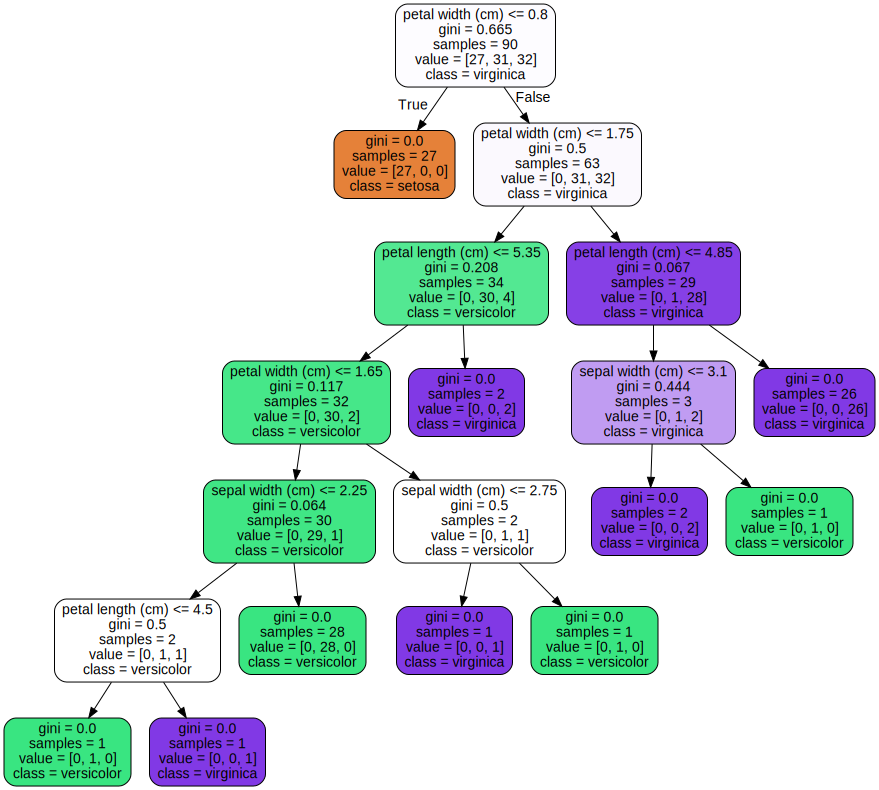

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
import graphviz
dot_data = tree.export_graphviz(dt_clf, out_file=None,class_names = iris.target_names,feature_names=iris.feature_names,filled=True, rounded=True) 
graph = graphviz.Source(dot_data) 
graph

To get you more familiar with the concept of decision tree, let's try another dataset of breast cancer.

In [17]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()
X = bc.data
y = bc.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
dt_clf.score(X_test,y_test)

0.9368421052631579

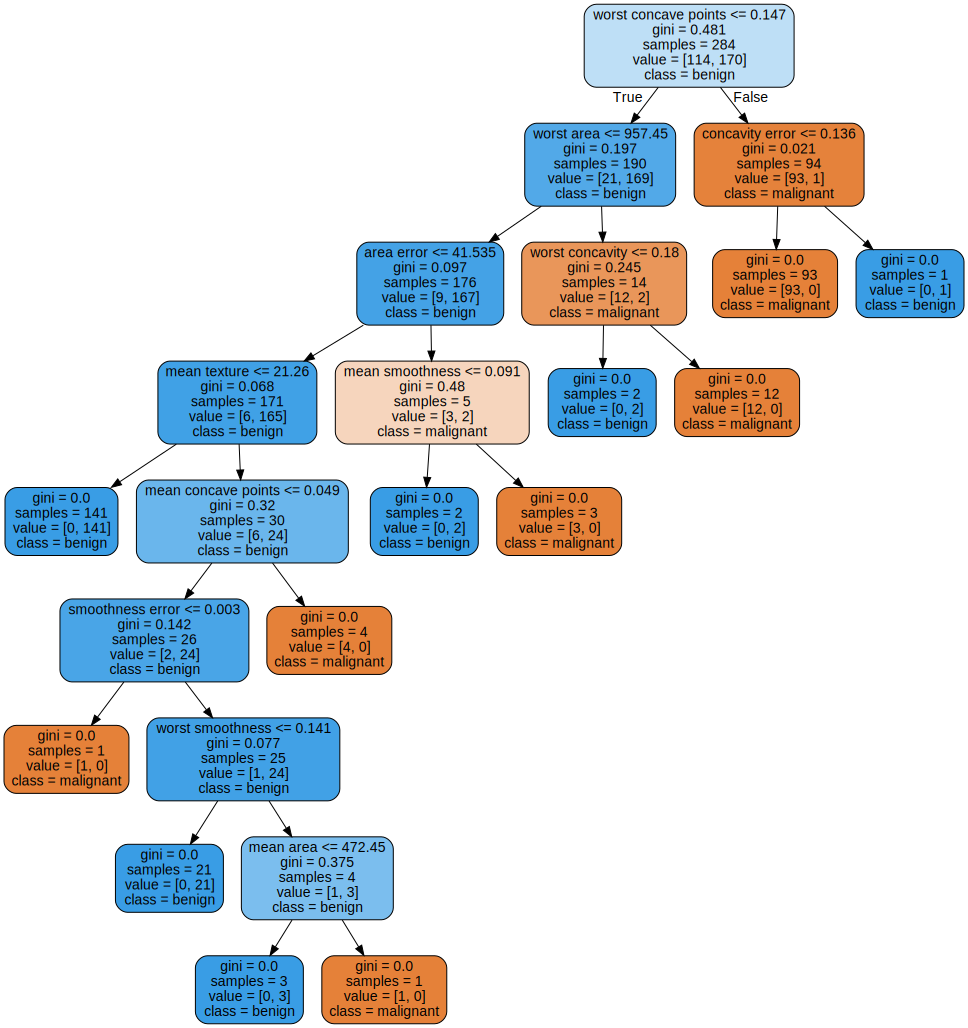

In [18]:
import graphviz 
dot_data = tree.export_graphviz(dt_clf, out_file=None,class_names = bc.target_names,feature_names=bc.feature_names,filled=True, rounded=True) 
graph = graphviz.Source(dot_data) 
graph

### Bias-Variance Tradeoff in DT:
The parameter tree depth is important to determine the final performance of classification, which can be understood as control the complexity of algorithm.
- deep tree: increase complexity, low bias, large variance
- shallow tree: decrease complexity, high bias, low variance

Typically, a decision tree tends to have large depth, making it prune to over-fitting (it just means the model is too complicated for the data, and the variance is too large, therefore causing the large error in testdataset).

## [Random Forest](https://en.wikipedia.org/wiki/Random_forest#:~:text=Random%20forests%20or%20random%20decision,average%20prediction%20(regression)%20of%20the) and [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html)

Despite that the idea of decision tree is very straightward, the method is notorious for its over-fitting and high variance.

To make the decision tree more robust, we can construct the "forest" of multiple trees, and let the forest of trees to "vote" -- naturally we think that it may reduce the variance in decision.

The each decision tree can be "random" (therefore different with each other) in two ways (this is also called bootstrapping in statistics):
   - In each run, we only pick up a random subset of **features** as training dataset
   - In each run, we only pick up a random subset of **samples** as training dataset

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, max_samples = 0.5, max_depth=5, random_state=0, n_jobs = -1) # make 1000 decision trees by random picking up 90% of the dataset, and each tree has the maximum depth of 5. njobs = -1 means you ask to use all the processors of your computer
rf_clf.fit(X_train, y_train) # note that we still work on the breast cancer dataset
rf_clf.score(X_test, y_test)

0.9614035087719298

**Hint for final projects:** In the majority classifier defined by sklearn, there's one parameter called `n_jobs` when initializing. Setting it to the value -1 will by default use all the cores in CPU to speed-up calculation. 

The same idea of random sampling training datasets to create and "unite" multiple classifiers can be applied to other supervised methods -- and the strategy is called **"bagging"** in machine learning.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
bagging_knn_clf = BaggingClassifier(KNeighborsClassifier(), n_estimators=100,max_samples=0.8, max_features=0.5, n_jobs = -1)
bagging_knn_clf.fit(X_train,y_train)
bagging_knn_clf.score(X_test,y_test)

0.9614035087719298

Besides create random classifiers by subsetting the dataset, another clever strategy is to let different classifiers "vote" -- this relates to the [wisdom of crowds](https://www.geeksforgeeks.org/ensemble-methods-and-wisdom-of-the-crowd/). This strategy is called **stacking**.

In [21]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

clf1 = LogisticRegression(max_iter=5000)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = SVC(kernel='rbf', probability=True)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svm', clf3)],voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'Ensemble']):
        scores_cv = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
        clf.fit(X_train,y_train)
        score_test = clf.score(X_test,y_test)
        print("Accuracy of CV: %0.2f (+/- %0.2f) [%s]" % (scores_cv.mean(), scores_cv.std(), label))
        print("Accuracy on Test: %0.2f [%s]" % (score_test, label))

Accuracy of CV: 0.94 (+/- 0.03) [Logistic Regression]
Accuracy on Test: 0.96 [Logistic Regression]
Accuracy of CV: 0.95 (+/- 0.01) [Random Forest]
Accuracy on Test: 0.97 [Random Forest]
Accuracy of CV: 0.88 (+/- 0.05) [Support Vector Machine]
Accuracy on Test: 0.93 [Support Vector Machine]
Accuracy of CV: 0.96 (+/- 0.02) [Ensemble]
Accuracy on Test: 0.98 [Ensemble]


Besides **bagging** and **stacking** ("unite" different weak classifiers in parallel), another common ensemble learning stragegy is called **boosting**, which "updates" the weak classifiers sequentially. Many popular machine learning methods nowadays ([XGBoost](https://xgboost.readthedocs.io/en/latest/), [lightGBM](https://lightgbm.readthedocs.io/en/latest/)) are based on this strategy. We won't cover these methods in our course, and you can refer to some materials [here](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205) if interested, and call PyCaret to use these methods.

### Reference Reading Suggestions:
- ISL: Chapter 8
- ESL: Chpater 9,10,13
- PML: Chapter 16,18